1. no subject wise validation...
2. is dataset balance?
3. What kind of transformation you did in train set and valid set
4. 

Same images appearing in both train & validation

Augmented versions of the same image leaking

Same patient appearing in both splits

Dataset duplicated or misloaded

In [1]:
import os
import random
import time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets, models
from tqdm import tqdm


## Import the dataset

In [2]:



#processed_dataset_path = 'C:\\Users\\user\\Documents\\GitHub\\IUT_Project_2025\\LIVER\\Liver Fibosis US-20251223T180246Z-1-002\\Liver Fibosis US\\Liver_Fibrosis_US'



processed_dataset_path = 'C:\\Users\\RAZER\\Documents\\GitHub\\IUT_Project_2025\\LIVER\\Liver Fibosis US-20251223T180246Z-1-002\\Liver Fibosis US\\Liver_Fibrosis_US'  # Update this path as needed


processed_dataset_path = 'C:\\Users\\RAZER\\Documents\\GitHub\\IUT_Project_2025\\LIVER\\Liver Fibosis US-20251223T180246Z-1-002\\Liver Fibosis US\\Liver_Fibrosis_US_processed'  # Update this path as needed


In [3]:
print(os.listdir(processed_dataset_path))


['F1', 'F2', 'F3', 'F4']


In [3]:
classes = os.listdir(processed_dataset_path)
print(classes)


['F1', 'F2', 'F3', 'F4']


## Train ResNet50 (pretrained on ImageNet)

Test mode only uses 5 images per class for training to allow a quick smoke test. Set to False for full training.

In [4]:
test_mode = False


### Hyperparameters

In [5]:
use_gpu = True  
random_seed = 42

# Hyperparameters 
batch_size = 8 if not test_mode else 8
num_epochs = 50 if not test_mode else 5
learning_rate = 1e-4
num_workers = 0
device = torch.device('cuda' if (use_gpu and torch.cuda.is_available()) else 'cpu')
print('Using device:', device)
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)


Using device: cuda


### Train-Test Split and DataLoaders

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],   # ImageNet normalization
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [14]:

to_tensor_only = transforms.Compose([
    transforms.ToTensor(),
])

# Create ImageFolder datasets with no transforms
full_train_dataset = datasets.ImageFolder(processed_dataset_path, transform=to_tensor_only)
full_val_dataset = datasets.ImageFolder(processed_dataset_path, transform=to_tensor_only)




'''# Create ImageFolder datasets with no transforms
full_train_dataset = datasets.ImageFolder(processed_dataset_path, transform=train_transform)
full_val_dataset = datasets.ImageFolder(processed_dataset_path, transform=val_transform)
'''



classes = full_train_dataset.classes
num_classes = len(classes)
print('Found classes:', classes)

# Build indices per class
indices_by_class = {i: [] for i in range(num_classes)}
for idx, (_, label) in enumerate(full_train_dataset.samples):
    indices_by_class[label].append(idx)

# For reproducibility shuffle each class list
for k in indices_by_class:
    random.shuffle(indices_by_class[k])

if test_mode:
    # select up to 5 samples per class for training, the rest become validation
    train_indices = []
    val_indices = []
    for k, idxs in indices_by_class.items():
        n_train_per_class = min(5, len(idxs))
        train_chunk = idxs[:n_train_per_class]
        val_chunk = idxs[n_train_per_class:]
        train_indices.extend(train_chunk)
        val_indices.extend(val_chunk)
else:
    # standard 80/20 split across the whole dataset
    n_total = len(full_train_dataset)
    n_train = int(0.8 * n_total)
    all_indices = list(range(n_total))
    random.shuffle(all_indices)
    train_indices = all_indices[:n_train]
    val_indices = all_indices[n_train:]

# Create Subset datasets
train_dataset = Subset(full_train_dataset, train_indices)
val_dataset = Subset(full_val_dataset, val_indices)
print(f'Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


Found classes: ['F1', 'F2', 'F3', 'F4']
Train samples: 1105, Val samples: 277


In [15]:
from collections import Counter

# labels from the full dataset
labels = [label for _, label in full_train_dataset.samples]

class_counts = Counter(labels)

# Map index → class name
for class_idx, count in class_counts.items():
    print(f"{full_train_dataset.classes[class_idx]}: {count}")


F1: 608
F2: 533
F3: 73
F4: 168


In [16]:
overlap = set(train_indices) & set(val_indices)
print("Overlap samples:", len(overlap))


Overlap samples: 0


In [16]:
from collections import Counter

val_labels = [full_val_dataset.samples[i][1] for i in val_indices]
print(Counter(val_labels))


Counter({1: 120, 0: 116, 3: 29, 2: 12})


In [17]:
print(len(train_loader.dataset), len(val_loader.dataset))
print(full_train_dataset.classes)



1105 277
['F1', 'F2', 'F3', 'F4']


In [18]:
from collections import Counter

train_labels = [full_train_dataset.samples[i][1] for i in train_indices]
train_dist = Counter(train_labels)

print("Train distribution:")
for k, v in train_dist.items():
    print(f"{classes[k]}: {v}")


Train distribution:
F4: 139
F2: 413
F1: 492
F3: 61


In [19]:
val_labels = [full_val_dataset.samples[i][1] for i in val_indices]
val_dist = Counter(val_labels)

print("\nValidation distribution:")
for k, v in val_dist.items():
    print(f"{classes[k]}: {v}")



Validation distribution:
F1: 116
F4: 29
F2: 120
F3: 12


### Model Config

In [20]:
# Build model
model = models.resnet50(weights='DEFAULT')

# Replace classifier
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Scheduler optional
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [21]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(loader, desc='Train', leave=False)
    for inputs, targets in pbar:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)
        pbar.set_postfix(loss=running_loss/total, acc=100. * correct/total)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_targets = []
    all_preds = []
    all_probs = []
    with torch.no_grad():
        pbar = tqdm(loader, desc='Eval', leave=False)
        for inputs, targets in pbar:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
            all_targets.extend(targets.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())
            all_probs.extend(probs.cpu().tolist())
    epoch_loss = running_loss / total if total>0 else 0
    epoch_acc = correct / total if total>0 else 0
    return epoch_loss, epoch_acc, all_targets, all_preds, all_probs


### Training Loop

In [22]:
# Training loop
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0.0
best_model_wts = None

patience = 7  # Stop if no improvement for 5 epochs

epochs_without_improvement = 0
start_time = time.time()
num_epochs = 5
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _, _ = evaluate(model, val_loader, criterion, device)
    scheduler.step()
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    print(f"Train loss: {train_loss:.4f} acc: {train_acc:.4f} | Val loss: {val_loss:.4f} acc: {val_acc:.4f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = {k: v.cpu() for k, v in model.state_dict().items()}
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    
    # Early stopping
    if epochs_without_improvement >= patience:
        print(f'Early stopping: no improvement for {patience} epochs')
        break

total_time = time.time() - start_time
print(f'Training complete in {total_time//60:.0f}m {total_time%60:.0f}s. Best val acc: {best_val_acc:.4f}')


Epoch 1/5


Train loss: 0.9234 acc: 0.6244 | Val loss: 0.8074 acc: 0.6679
Epoch 2/5


Train loss: 0.6725 acc: 0.7285 | Val loss: 0.8004 acc: 0.6679
Epoch 3/5


Train loss: 0.4694 acc: 0.8344 | Val loss: 0.4879 acc: 0.8267
Epoch 4/5


Train loss: 0.2953 acc: 0.8950 | Val loss: 0.5217 acc: 0.7978
Epoch 5/5


Train loss: 0.1746 acc: 0.9502 | Val loss: 0.4759 acc: 0.8592
Training complete in 4m 48s. Best val acc: 0.8592


### Loading the model

In [24]:
# Load best weights back into model
if best_model_wts is not None:
    model.load_state_dict(best_model_wts)

# Evaluate on validation set and collect predictions
val_loss, val_acc, val_targets, val_preds, val_probs = evaluate(model, val_loader, criterion, device)
print(f'Final val loss: {val_loss:.4f}, val acc: {val_acc:.4f}')


Final val loss: 0.4759, val acc: 0.8592


### Plotting Training Curves

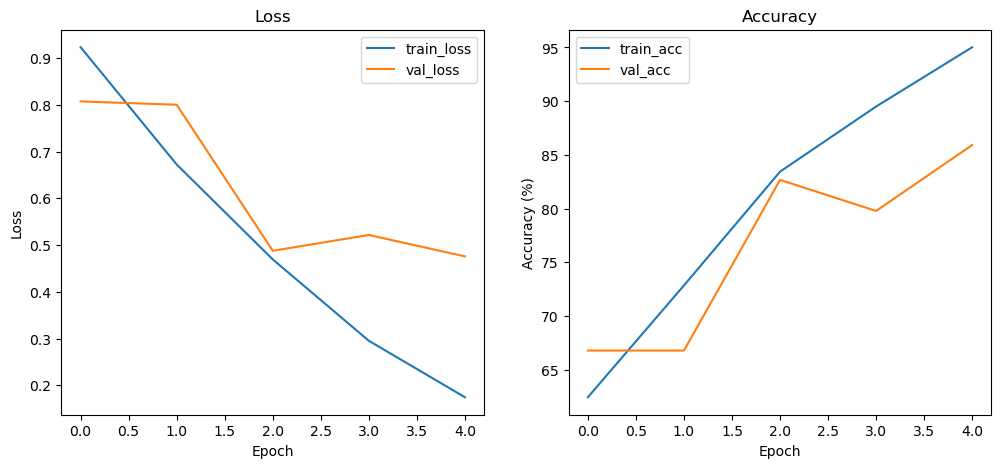

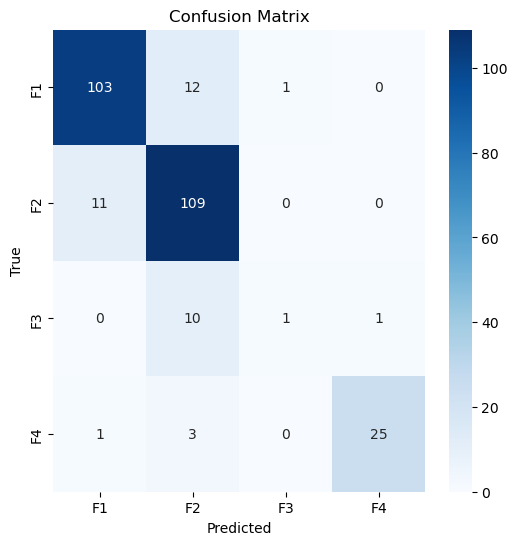


Classification report:
              precision    recall  f1-score   support

          F1       0.90      0.89      0.89       116
          F2       0.81      0.91      0.86       120
          F3       0.50      0.08      0.14        12
          F4       0.96      0.86      0.91        29

    accuracy                           0.86       277
   macro avg       0.79      0.69      0.70       277
weighted avg       0.85      0.86      0.85       277



In [25]:
# Plot training curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot([x*100 for x in history['train_acc']], label='train_acc')
plt.plot([x*100 for x in history['val_acc']], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy')
plt.show()
# Confusion matrix (small datasets may have classes missing in val)
try:
    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(val_targets, val_preds, labels=list(range(num_classes)))
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    print('\nClassification report:')
    print(classification_report(val_targets, val_preds, target_names=classes, zero_division=0))
except Exception as e:
    print('Could not compute confusion matrix or classification report:', e)


### Exporting the Model

In [13]:
# Export model
out_dir = Path('outputs')
out_dir.mkdir(parents=True, exist_ok=True)

# Save state_dict
torch.save(model.state_dict(), out_dir / 'resnet50_state_dict.pth')

# Save full model (may be large)
torch.save(model, out_dir / 'resnet50_full_model.pt')

print(f'Saved model to {out_dir}')
print(f'  - State dict: {out_dir / "resnet50_state_dict.pth"}')
print(f'  - Full model: {out_dir / "resnet50_full_model.pt"}')


Saved model to outputs
  - State dict: outputs/resnet50_state_dict.pth
  - Full model: outputs/resnet50_full_model.pt
